In [3]:
# Importing all relevant modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition

# Data-Preprocessing:

<h2>Structure of the final dataset:</h2>

The data is compiled in the form of a pandas dataframe along with the sensor information and gait type as label names. Each cell of the dataframe is a list whcih contains multiple numpy arrays. Each of those numpy arrays in one list represent a sample/cycle of a single trial having a constant number of datapoints. Thus, essentially each list corresponds to the preprocessed data of a single trial of a single subject doing a particular gait (normal walking/upstairs walking/downstairs walking). Corresponding to each list, the type of gait is also stored as label name. Since scope of this project covers both acceleration and gyroscope sensor datas, 2 such dataframes are created, one for each sensor.

<h2>Parsing raw sensor data from csv files</h2>

The raw sensor data is extracted in the form of a dictionary, with the keys of the dictionary being the sanpling frequency of the corresponding csv files, and the values being the corresponding X, Y and Z time series in the csv files. The experiment names (gait types) are also extracted as a seperate list.


In [4]:
# Data Paring Function:
import glob
import re
import numpy as np
import pandas as pd

#%% Global Variables
global coFreqAcc # Cut-off frequency for acceleration data
global coFreqGyr # Cut-off frequency for gyroscope data
coFreqAcc = 5 # Hz
coFreqGyr = 1 # Hz

#%% ******************* Desired Output of the Function *************************************
    # -> Sampling frequencies of all csv files being read
    # -> Time vectors of all csv files being read
    # -> X,Y,Z readings of acclerometer sensors for all subject files being read
    # -> X,Y,Z readings of gyroscope sensors for all subject files being read
    # -> All data is returned as lists




#%% ***************** Structure of the dataset:**************************
    # Home Folder -> Smartphone1
    #             -> Smartphone2
    #             -> Smartphone3 
    #                           -> subject<Subject#>_<GaitType><Trial#>
    #                                                                 -> Accelerometer.csv
    #                                                                 -> Gyroscope.csv
    #             -> Smartphone4
#********************************************************************************************



#%% Starting Data Parsing

def dataParser():
    
    print('Starting Data Parsing')
    
    # Required Subject IDs -> Which Subject Data are taken
    startSub = 150
    endSub = 274
    numSub = endSub - startSub + 1
    subjID = list(np.linspace(startSub,endSub,numSub))
    # subjID = ['155','224','257']
    
    # Accesing all folders inside the Smartphone 3 folder
    folders = glob.glob(r'./ProjectAData/Data/Smartphone3/*')  # folders is a list containing all folder names as strings
    
    
    # Initialising empty dictionary for storing all acceleration and gyroscope data
    
    # The keys in the dictionary will be the sampling frequencies and experiment names corresponding to each csv file
    # The values in the dictionary will be the 2D arrays containing the entire csv data
    
    AccData = {} # Dictionary for Acceleration data
    GyrData = {} # Dictionary for gyroscope data
    
    # Empty List for storing experiment names
    exp = []
    
    
    for folder in folders:
        
        # Ensuring the impaired folders are not accessed since they don't come under our scope
        # Any folder name having the series of characters 'red' in it will be skipped
        if re.search(r'red', folder) or re.search(r'cap', folder):
            continue # The next iteration is carried out
        # print(folder)
        
        # How each folder name (folder) look like: some examples
        # ./ProjectAData/Data/Smartphone3\subject196_normal02
        # ./ProjectAData/Data/Smartphone3\subject197_downstairs01
        # ./ProjectAData/Data/Smartphone3\subject197_downstairs02
        
        # We have to ensure that we don't access any impaired folders for any of the subjects
        
        # Splitting of folder names:
            # -> Experiment Type (Upstaris, downstairs)
            # -> Subject Number
        
        Split1 = re.split('/',folder) # Splitting each folder name
        Split1 = Split1[-1]
        Split2 = re.split('_',Split1)
        experiment = Split2[-1]
        experiment = re.split('0',experiment)
        experiment = experiment[0]
        Split2 = Split2[0]
        Split3 = re.split('t',Split2)
        subjectNum = Split3[-1]
        
        
        # Accesing the accelerometer and gyroscope files for the matching subject ids
        if float(subjectNum) in subjID and float(subjectNum) != 218 and float(subjectNum) != 222 and float(subjectNum) != 270: 
            # Subject 218 folder files are not in the right format
            # Subject 222 upstairs trial 01 folder doesn't have accelerometer file so the entire subject skipped
            # Subject 270 downstairs trial 02 folder doesn't have gyroscope file so the entire subject skipped
            gyr_file = glob.glob(folder+'/Gyroscope.csv')
            acc_file = glob.glob(folder+'/Accelerometer.csv')
            
            # gyr_file and acc_file are lists of size 1 with the onky element being the path name to the corresponding
            # gyroscope or acclerometer files
            # Example:
               # ['./ProjectAData/Data/Smartphone3\\subject216_normal02/Accelerometer.csv']
               # the above is one such acc_file when the subject ID of 216 matches
            
            # print(acc_file)
            # print(gyr_file)
            # print(subjectNum)
            
            # Extracting the accelerometer and gyroscope data
            data_gyr = pd.read_csv(gyr_file[0],sep = ",", header = None) # data_gyr is a dataframe
            # From the above dataframe, we are going to extract the X,Y,Z time series and assemble it into a 2D numpy array
            # The first row of the dataframe corresponds to the headers so that has to be skipped too
            # Remember -> Indexing starts from 0
            gyr = data_gyr.iloc[1:,0:4].values.astype(float) # gyr is a 2D numpy array containing the entire csv file
            # print(data_gyr)
            # print(gyr)
            
            data_acc = pd.read_csv(acc_file[0],sep = ",", header = None)
            acc = data_acc.iloc[1:,0:4].values.astype(float) # Columns 0,1,2,3 are read (Index 4 is left out, similar to range)
            # print(data_acc)
            # print(acc)
            
            # Computing Sampling Frequency:
                # Sampling Frequency = (# Datapoints in the csv)/(Experiment Time)
                # Experiment Time = Last element of the type vector
                # # Datapoints in the csv = number of rows in the 2D array
                
            sampFreqAcc = np.shape(acc)[0]/acc[-1,0]
            sampFreqGyr = np.shape(gyr)[0]/gyr[-1,0]
            
            # Due to some errors in data measurement, some sampling frequencies have blatantly wrong values (for eg. 0.3 Hz)
            # Since for using digital filters, we require the digital filter critical frequency to be between 0 and 1
            if sampFreqAcc < 2*coFreqAcc or sampFreqGyr < 2*coFreqGyr:
                continue # The entire subject is skipped
            
            
            # Dictionary keys have to be immutable only (like tuples)
            keyAcc = sampFreqAcc
            keyGyr = sampFreqGyr
            
            # Adding elements to the acceleration and gyroscope dictionaries
            AccData[keyAcc] = acc # The accelerometer file sampling frequency is the key and the csv data is the value
            GyrData[keyGyr] = gyr # The gyroscope file sampling frequency is the key and the csv data is the value
            
            # Appending experiment names to the experiment list
            exp.append(experiment)
            
            # Printing the subject numbers and corresponding experiments whose files are accessed for reference
            print(subjectNum,experiment)
            
    # print(AccData)
        
    print('Ending Data Parsing')
    return AccData, GyrData, exp

<h2>Data Filtering</h2>

Fast fourier transforms can be used to judge the cut-off frequencies required to effectively filter out noise in the raw sensor data. A fourth order butterworth low pass filter is used. Based on the frequency domain plots obtained from FFT, we can set a standard cut-off frequencies for each of the sensor data. Even though different activities will tend to have different appropriate cut-off frequencies (for example, downstairs walking will tend to have more *jerky* movements and thus will have higher constituent frequencies than normal even walking), we can still use a standard cut-off frequency for all gaits since we will be inputing time series in the neural network which means *pattern recognition* becomes the main learning task for the neural network. Thus, even though some valuable information may be lost due to low cut-off frequencies for gait trials like downstairs walking, the overall gait patttern which needs to be recognised will stay the same. 

In [5]:
# Function for data filtering
#**************************** Filtering Data *********************************
# Filter Used: 4th Order Low Pass Butterworth Filter


# Importing the signal module from Scipy
from scipy import signal

def dataFilter(in_signal,order,coFreq,sampFreq):
    
    [b,a] = signal.butter(order,coFreq/(sampFreq/2),'low')
    out_signal = signal.filtfilt(b,a,in_signal)
    return out_signal

<h2>Extracting Motion Sequence</h2>

For all the trials, the data at the beginning and the end of the trial will most likely be garbage data since at the start of the trial, the subject prepares to start walking and at the end of the trial, the subject abruptly stops. Thus, the actual motion is usually not reflected in these instances of the data and thus these instances need to be cut out.

In [6]:
# Function for extracting motion sequence

# Modules
import numpy as np
# import matplotlib.pyplot as plt
from scipy import signal

#%% Function For cutting the data and extracting Motion Sequence

#%% Primarliy the data aat the beginning of the trials have to be left out since
# there may have been some lag in starting the movement at the start of the trials
# and thus the starting data won't be a part of the motion sequence
# Similarly with the end few datapoints when the subject is finishing the trials


# Data is cut based on the occurance of peaks in the data
# The norms of the data are taken along the rows i.e.:
    # Sample Acceleration Data as 2D array:
        #accX   accY    accZ
        #acc_abs(for one row) = square summation of accX, accY and accZ
    # By usig norms, we get one time series with the value of each element in
    # the series being the norm across the rows (X,Y and Z)
        
#%% Function Definition

# Empty placeholder lists
accEmp = []
gyrEmp = []

def dataCut(acc, gyr, accfreq, gyrfreq): # 2D arrays containing data in all 3D coordinates are input to te function
    # Taking norms across columns in each row and converting into one time series
    acc_abs = np.linalg.norm(acc,axis = 1)
    # fig = plt.figure(figsize = (10,10))
    # plt.plot(acc_abs)
    
    # The peaks having having height lesser than 11 m/s2 are not considered
    peaks, _ = signal.find_peaks(acc_abs,height=11) # peaks will be the index numbers at which the peaks (local maxima) occur
    diff_peaks = np.diff(peaks) # diff_peaks gives us the diffference between the index numbers of consecutive peaks
    gap1  = np.argmax(diff_peaks[:20]) # Largest difference index number betwween consecutive peak indices in the first 20 peaks
    gap2  = np.argmax(diff_peaks[-10:]) # Largest difference index number betwween consecutive peak indices in the last 10 peaks
    gap2  = int(gap2 + np.shape(diff_peaks)[0]-10) # gap2 index number is defined wrt start of the indices 

    if (gap2 + np.shape(diff_peaks)[0]) < 11: # For some datasets, the gap2 index becomes negative, those datasets are omitted
        return accEmp,gyrEmp
    
    else:
        # Extracted Motion Sequence
        acc_cut = acc[peaks[gap1+1]:peaks[gap2],:]
        gyr_cut = gyr[peaks[gap1+1]:peaks[gap2],:]
    
        print('Motion Sequence Extracted')
    
        return acc_cut, gyr_cut # Cut 2D arrays returned


<h2>Reducing dimensionality and rotating the data</h2>

Since the orientation of the phones were not standardised and fixed while taking the data, the sensor data values across all trials are not with respect to a standard inertial frame. Thus, the data across all trials needs to be rotated properly. Additionally, it also makes sense to reduce the dimensionality of the data.

In this project, 2 such methods are looked at:
* Principle Component Analysis
* Root Mean Sqaure of nornalised data points

A standard python module and code base is used to apply the principle component analysis. For normalising the dataset, the means of X, Y and Z time series are computed and the distribution of datasets about the mean are computed. Once, the data is normalised, the RMS of the data is computed.


<h2>Segmentation of data into sample/cycles</h2>

In [7]:
# Function for data segmentation
from scipy import signal
import numpy as np

#%% Function Definition
def dataSegment(acc,gyr,rot):
    
    if rot == 'PCA':
        # Peak Finding when PCA is used
        peaksAcc, _ = signal.find_peaks(acc,height = 2) # Returns indices of peaks in acceleration data
        peaksGyr, _ = signal.find_peaks(gyr,height = 1.4) # Returns indices of peaks in gyroscope data
        
    elif rot == 'RMS':
        # Peak Finding when RMS of normalised values are used
        peaksAcc, _ = signal.find_peaks(acc,height = 1.2) # Returns indices of peaks in acceleration data
        peaksGyr, _ = signal.find_peaks(gyr,height = 0.4) # Returns indices of peaks in gyroscope data
    
# ===============================s==============================================
#     diff_peaksAcc = np.diff(peaksAcc)
#     diff_peaksGyr = np.diff(peaksGyr)
# =============================================================================
    
    # We return a list wherer each element of the list is the individual cycle/sample
    # The data arrays are sliced into multiple cycles on the basis of peak indices obtained
    
    # Initialising lists
    segAcc = []
    segGyr = []

# =============================================================================
#     segAcc = np.empty((peaksAcc.shape[0],100))
#     segGyr = np.empty((peaksGyr.shape[0],100))
#     
# =============================================================================
    jj = 0
    for ii in peaksAcc:
        cycAcc = acc[jj:ii + 1] # Cycle obtained as array
        cycAcc = signal.resample(cycAcc,100)
        segAcc.append(cycAcc)
        jj = ii + 1
        #print(segAcc,type(segAcc))
            
        
        
    jj = 0
    for ii in peaksGyr:
        cycGyr = gyr[jj:ii + 1] # Cycle obtained 
        cycGyr = signal.resample(cycGyr,100)
        segGyr.append(cycGyr)
        jj = ii + 1

    return segAcc,segGyr # Lists with each elements being the segmented cycles are returned


<h2>Removing Malicious Data</h2>

Starting Data Parsing
150 downstairs
150 downstairs
150 normal
150 normal
150 upstairs
150 upstairs
151 downstairs
151 downstairs
151 normal
151 normal
151 upstairs
151 upstairs
152 downstairs
152 downstairs
152 normal
152 normal
152 upstairs
152 upstairs
153 downstairs
153 downstairs
153 normal
153 normal
153 upstairs
153 upstairs
154 downstairs
154 downstairs
154 normal
154 normal
154 upstairs
154 upstairs
155 downstairs
155 downstairs
155 normal
155 normal
155 normal
155 upstairs
155 upstairs
156 normal
156 normal
157 downstairs
157 downstairs
157 normal
157 normal
157 upstairs
157 upstairs
158 normal
159 downstairs
159 downstairs
159 normal
159 normal
159 upstairs
159 upstairs
160 downstairs
160 downstairs
160 normal
160 normal
160 upstairs
160 upstairs
162 downstairs
162 downstairs
162 normal
162 normal
162 upstairs
162 upstairs
163 normal
163 normal
163 upstairs
163 upstairs
164 normal
164 normal
164 upstairs
164 upstairs
165 downstairs
165 downstairs
165 normal
165 normal
165 up

C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Seque

Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Seque

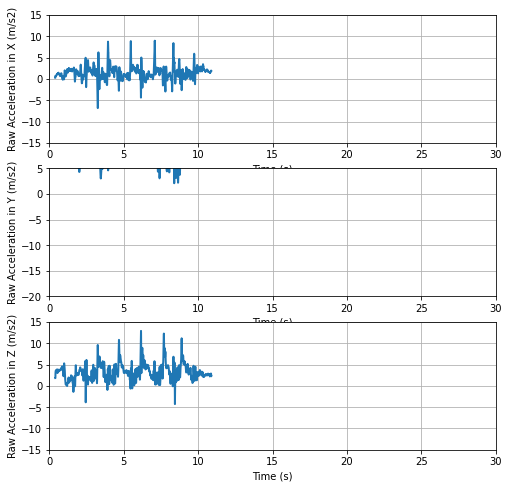

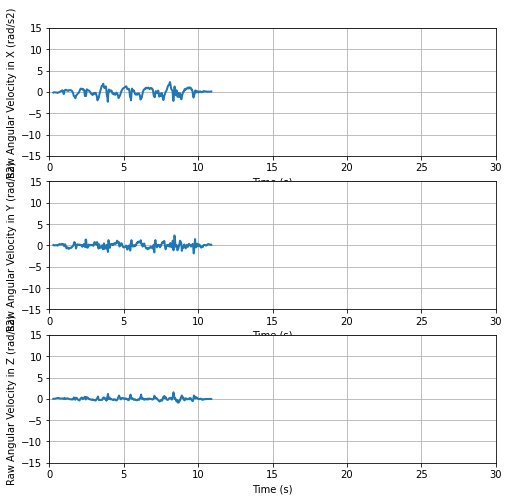

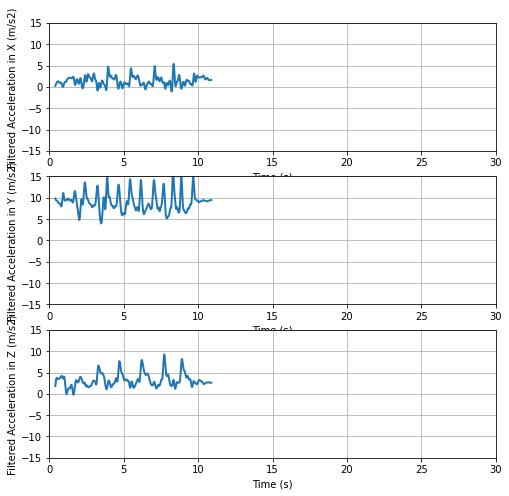

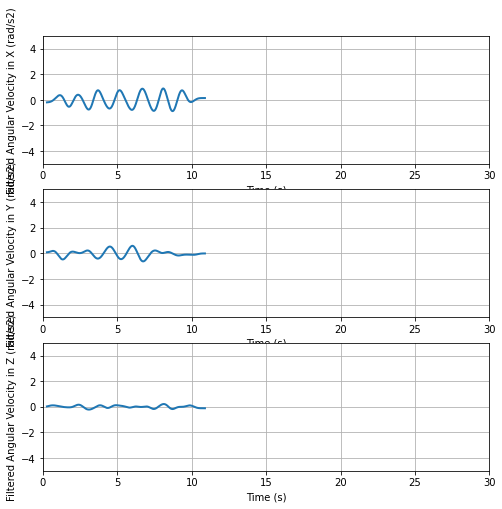

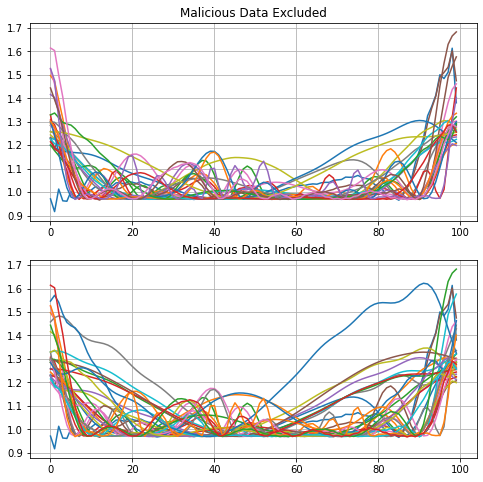

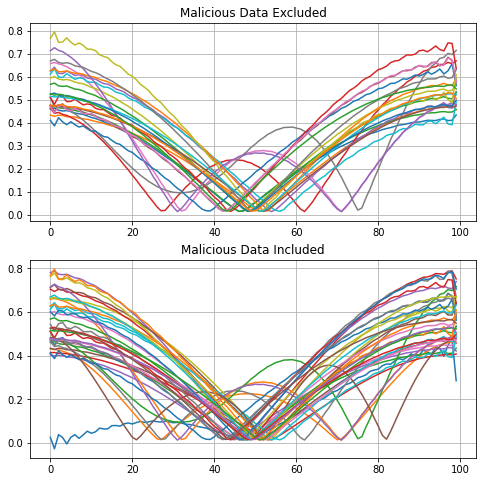

In [8]:
# Mother Script
#%% Global Variables
global coFreqAcc # Cut-off frequency for acceleration data
global coFreqGyr # Cut-off frequency for gyroscope data
coFreqAcc = 5 # Hz
coFreqGyr = 1 # Hz

#%% Method for Rotating and Standardising Data
# 1). PCA (principle component analysis) -> 'PCA'
# 2). RMS of normalised time series -> 'RMS'

rot = 'PCA'

#%% Dataframes for accumulating data
colNames = ['Trials','Sensor','Gait']
accData = pd.DataFrame(columns = colNames)
gyrData = pd.DataFrame(columns = colNames)
# =============================================================================
# accData = pd.DataFrame(columns = colNames)
# gyrData = pd.DataFrame(columns = colNames)
# =============================================================================


#%% Obtaining all pertinent data for the mentioned subject numbers
AccData,GyrData,experiments = dataParser()

# All sampling Frequencies
sampfreqAcc = list(AccData.keys()) # All acceleration files sampling frequencies
sampfreqGyr = list(GyrData.keys()) # All gyroscope files sampling frequencies

# All csv data
acc = list(AccData.values())
gyr = list(GyrData.values())



#%% Extracting Sample Raw Data
ax = acc[1][:,1]
ay = acc[1][:,2]
az = acc[1][:,3]
ta = acc[1][:,0]

gx = gyr[1][:,1]
gy = gyr[1][:,2]
gz = gyr[1][:,3]
tg = gyr[1][:,0]
print('Raw Data Extracted')

#%% Plotting Raw Data
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))

axis1.plot(acc[0][:,0],acc[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Raw Acceleration in X (m/s2)')
axis1.axis([0,30,-15,15])
axis1.grid()


axis2.plot(acc[0][:,0],acc[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Raw Acceleration in Y (m/s2)')
axis2.axis([0,30,-20,5])
axis2.grid()

axis3.plot(acc[0][:,0],acc[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Raw Acceleration in Z (m/s2)')
axis3.axis([0,30,-15,15])
axis3.axis([0,30,-15,15])
axis3.grid()
print('Raw Acceleration Plotted')

fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))

axis1.plot(gyr[0][:,0],gyr[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Raw Angular Velocity in X (rad/s2)')
axis1.axis([0,30,-15,15])
axis1.grid()


axis2.plot(gyr[0][:,0],gyr[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Raw Angular Velocity in Y (rad/s2)')
axis2.axis([0,30,-15,15])
axis2.axis([0,30,-15,15])
axis2.grid()

axis3.plot(gyr[0][:,0],gyr[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Raw Angular Velocity in Z (rad/s2)')
axis3.axis([0,30,-15,15])
axis3.axis([0,30,-15,15])
axis3.grid()
print('Raw Angular Velocity Plotted')

#%% Using FFT to get an idea about the cut-off frequencies
# Deciding cut-off frequency for filtering
# Using FFT (Fast Fourier Transform)
# The frequency for which the frequency strength stops having significant peaks, that can 
# be assumed to be the cut-off frequency

# =============================================================================
# yfx = rfft(ax) # rfft(Raw Signal)
# xfx = rfftfreq(np.size(ax),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfx,abs(yfx))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# # plt.axis([0,50,0,14000])
# 
# yfy = rfft(ay) # rfft(Raw Signal)
# xfy = rfftfreq(np.size(ay),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfy,abs(yfy))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# # plt.axis([0,50,0,14000])
# 
# yfz = rfft(az) # rfft(Raw Signal)
# xfz = rfftfreq(np.size(az),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfz,abs(yfz))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# # plt.axis([0,50,0,14000])
# =============================================================================

# =============================================================================
# yfxg = rfft(gx) # rfft(Raw Signal)
# xfxg = rfftfreq(np.size(gx),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfxg,abs(yfxg))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# 
# yfyg = rfft(gy) # rfft(Raw Signal)
# xfyg = rfftfreq(np.size(gy),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfyg,abs(yfyg))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# 
# yfzg = rfft(gz) # rfft(Raw Signal)
# xfzg = rfftfreq(np.size(gz),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)
# fig = plt.figure(figsize = (10,10))
# plt.plot(xfzg,abs(yfzg))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Frequency Strength')
# plt.grid()
# =============================================================================




#%% Filtering the Data
for i in range(0,len(acc)):
    acc[i][:,1] = dataFilter(acc[i][:,1],4,coFreqAcc,sampfreqAcc[i])
    acc[i][:,2] = dataFilter(acc[i][:,2],4,coFreqAcc,sampfreqAcc[i])
    acc[i][:,3] = dataFilter(acc[i][:,3],4,coFreqAcc,sampfreqAcc[i])
    
for j in range(0,len(gyr)):
    gyr[j][:,1] = dataFilter(gyr[j][:,1],4,coFreqGyr,sampfreqGyr[j])
    gyr[j][:,2] = dataFilter(gyr[j][:,2],4,coFreqGyr,sampfreqGyr[j])
    gyr[j][:,3] = dataFilter(gyr[j][:,3],4,coFreqGyr,sampfreqGyr[j])
    
    
print('Data Filtered')

#%% Plotting Filtered Data
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))

axis1.plot(acc[0][:,0],acc[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Filtered Acceleration in X (m/s2)')
axis1.axis([0,30,-15,15])
axis1.grid()

axis2.plot(acc[0][:,0],acc[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Filtered Acceleration in Y (m/s2)')
axis2.axis([0,30,-15,15])
axis2.axis([0,30,-15,15])
axis2.grid()

axis3.plot(acc[0][:,0],acc[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Filtered Acceleration in Z (m/s2)')
axis3.axis([0,30,-15,15])
axis3.axis([0,30,-15,15])
axis3.grid()
print('Filtered Acceleration Plotted')


fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))

axis1.plot(gyr[0][:,0],gyr[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Filtered Angular Velocity in X (rad/s2)')
axis1.axis([0,30,-5,5])
axis1.grid()


axis2.plot(gyr[0][:,0],gyr[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Filtered Angular Velocity in Y (rad/s2)')
axis2.axis([0,30,-15,15])
axis2.axis([0,30,-5,5])
axis2.grid()

axis3.plot(gyr[0][:,0],gyr[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Filtered Angular Velocity in Z (rad/s2)')
axis3.axis([0,30,-5,5])
axis3.grid()
print('Filtered Angular Velocity Plotted')  

#%% Further Preprocessing
# Empty List for New Processed acceleration data
acc1 = []
# Empty List for New Processed gyroscope data
gyr1 = []

count = 0
firstsegAcc = []
firstsegGyr = []
for i in range(0,len(acc)):
    #%% Cutting Data
    acc_cut,gyr_cut = dataCut(acc[i][:,1:4],gyr[i][:,1:4],sampfreqAcc[i],sampfreqGyr[i])
    
    if len(acc_cut) == 0 or len(gyr_cut) == 0:
        continue
    
    if np.shape(gyr_cut)[0] == 0 or np.shape(acc_cut)[0] == 0: # Some issues in some trials where gyroscope data vanishes
                                  # after cutting the data -> Trials where that is happening 
                                  # are omitted for now
        continue
    
    #%% Rotating and Reducing Dimensionality of Data -> Principle Component Analysis
    
    if rot == 'PCA':
        
        data_gyr = scale(gyr_cut)
        pca_gyr = decomposition.PCA(n_components=1) # Number of prinicple component axes = 1
        pca_gyr.fit(data_gyr)
        trans_gyr = pca_gyr.transform(data_gyr)
        # trans_df_gyr = pd.DataFrame(trans_gyr)
        data_acc = scale(acc_cut)
        pca_acc = decomposition.PCA(n_components=1)
        pca_acc.fit(data_acc)
        trans_acc = pca_acc.transform(data_acc)
        # trans_df_acc = pd.DataFrame(trans_acc)
        
        
    # Rotating and Reducing Dimensionality of Data -> RMS Time series    
        
    elif rot == 'RMS':
    
        # Normalising the data
        
        # Acceleration
        # Means of X,Y,Z time series
        x_mean = np.mean(acc_cut[:,0])
        y_mean = np.mean(acc_cut[:,1])
        z_mean = np.mean(acc_cut[:,2])
        
        # Max of X,Y,Z time series
        x_max = np.max(acc_cut[:,0])
        y_max = np.max(acc_cut[:,1])
        z_max = np.max(acc_cut[:,2])
        
        trans_acc = np.empty((np.shape(acc_cut)[0],1)) # empty array for storing the RMS time series of acceleration data
        
        # Normalised Data -> Between -1 and 1
        # Values smaller than mean will be in [-1,0] and values greater than mean will be [0,1]
        for ii in range(0,np.shape(acc_cut)[0]):
    
            x_norm = (acc_cut[ii,0] - x_mean)/(x_max - x_mean)
            y_norm = (acc_cut[ii,0] - y_mean)/(y_max - y_mean)
            z_norm = (acc_cut[ii,0] - z_mean)/(z_max - z_mean)
            
            trans_acc[ii] = np.sqrt((np.power(x_norm,2) + np.power(y_norm,2) + np.power(z_norm,2))/(3))
            
            
        # Gyroscope
        # Means of X,Y,Z time series
        x_mean = np.mean(gyr_cut[:,0])
        y_mean = np.mean(gyr_cut[:,1])
        z_mean = np.mean(gyr_cut[:,2])
        
        # Max of X,Y,Z time series
        x_max = np.max(gyr_cut[:,0])
        y_max = np.max(gyr_cut[:,1])
        z_max = np.max(gyr_cut[:,2])
        
        trans_gyr = np.empty((np.shape(gyr_cut)[0],1)) # empty array for storing the RMS time series of acceleration data
        
        # Normalised Data -> Between -1 and 1
        # Values smaller than mean will be in [-1,0] and values greater than mean will be [0,1]
        for ii in range(0,np.shape(gyr_cut)[0]):
    
            x_norm = (gyr_cut[ii,0] - x_mean)/(x_max - x_mean)
            y_norm = (gyr_cut[ii,0] - y_mean)/(y_max - y_mean)
            z_norm = (gyr_cut[ii,0] - z_mean)/(z_max - z_mean)
            
            trans_gyr[ii] = np.sqrt((np.power(x_norm,2) + np.power(y_norm,2) + np.power(z_norm,2))/(3))
            
        
        
            
    
    #%% Segmenting the data and resampling the cycles
    segAcc, segGyr = dataSegment(trans_acc[:,0],trans_gyr[:,0],rot)

    
    if i == 6:
        firstsegAcc = segAcc
        firstsegGyr = segGyr

    
    
    #%% Accumilating the Data
    accData['Trials'] = accData['Trials'].astype('object')
    gyrData['Trials'] = gyrData['Trials'].astype('object')
    
    
    #%% Removing Malicious Data
    
    # Array for storing mean of each cycle
    meanCycle = np.zeros(len(segAcc))
    for ii in range(0,len(segAcc)):
        meanCycle[ii] = np.mean(segAcc[ii])
        
    meanCycleMean = np.mean(meanCycle) # Mean of all cycle means
    
    # Standard Deviation of cycle means wrt mean of cycle means
    sigma = np.std(meanCycle)
    
    segAcc_nonmal =[]
    
    for ii in range(0,meanCycle.shape[0]):
        if meanCycle[ii] >= (meanCycleMean + sigma) or meanCycle[ii] <= (meanCycleMean - sigma):
            continue # The particular cycle is removed
        else:
            segAcc_nonmal.append(segAcc[ii]) # List containing non-malicious cycles as arrays
            
    
    # Array for storing mean of each cycle
    meanCycle = np.zeros(len(segGyr))
    for iter in range(len(segGyr)):
        meanCycle[iter] = np.mean(segGyr[iter])
        
    meanCycleMean = np.mean(meanCycle) # Mean of all cycle means
    
    # Standard Deviation of cycle means wrt mean of cycle means
    sigma = np.std(meanCycle)
    
    segGyr_nonmal = []
    
    for ii in range(len(segGyr)):
        if meanCycle[ii] >= (meanCycleMean + sigma) or meanCycle[ii] <= (meanCycleMean - sigma)  :
            continue # The particular cycle is removed
        else:
            segGyr_nonmal.append(segGyr[ii]) # List containing non-malicious cycles as arrays
    
    
    # accData.at[count,'Trials'] = segAcc_nonmal
    # gyrData.at[count,'Trials'] = segGyr_nonmal
    
    
    for i in range(0,len(segAcc_nonmal)):
        for j in range(0,segAcc_nonmal[i].shape):
            accData.at[count,j] = segAcc_nonmal[i][j]
            
    for i in range(0,len(segGyr_nonmal)):
        for j in range(0,segGyr_nonmal[i].shape):
            accData.at[count,j] = segGyr_nonmal[i][j]
    
    accData.at[count,'Sensor'] = 'Accelerometer'
    gyrData.at[count,'Sensor'] = 'Gyroscope'
    
    accData.at[count,'Gait'] = experiments[i]
    gyrData.at[count,'Gait'] = experiments[i]

    # Data stores alternatively as lists
    acc1.append(segAcc_nonmal)
    gyr1.append(segGyr_nonmal)
    
    count = count+ 1
        
# Sample Cycles

# Acceleration
fig, (axis1,axis2) = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8))
for i in range(len(accData.at[2,'Trials'])):
    axis1.plot(accData.at[2,'Trials'][i])
axis1.title.set_text('Malicious Data Excluded')
axis1.grid()

for i in range(len(firstsegAcc)):
    axis2.plot(firstsegAcc[i])
axis2.title.set_text('Malicious Data Included')
axis2.grid()
plt.show()


# Gyroscope
fig, (axis1,axis2) = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8))
for i in range(len(gyrData.at[2,'Trials'])):
    axis1.plot(gyrData.at[2,'Trials'][i])
axis1.title.set_text('Malicious Data Excluded')
axis1.grid()

for i in range(len(firstsegGyr)):
    axis2.plot(firstsegGyr[i])
axis2.title.set_text('Malicious Data Included')
axis2.grid()
plt.show()

In [9]:
print(accData)

                                                Trials         Sensor  \
0    [[1.7481846552864475, 1.7232769939587247, 1.77...  Accelerometer   
1    [[1.3690111350646534, 1.3349384438619598, 1.36...  Accelerometer   
2    [[0.9711354995956456, 0.916958388773959, 1.013...  Accelerometer   
3    [[1.2521961765078768, 1.2444619679692983, 1.22...  Accelerometer   
4    [[1.4460328156657611, 1.32629513559533, 1.3554...  Accelerometer   
..                                                 ...            ...   
470  [[1.3111152400387436, 1.2294820596864278, 1.26...  Accelerometer   
471  [[1.2068445496462992, 1.1678634577406255, 1.11...  Accelerometer   
472  [[1.2825555721175816, 1.2041065257413768, 1.18...  Accelerometer   
473  [[1.8456225633575836, 1.875795127267956, 1.874...  Accelerometer   
474  [[2.2044238374511336, 2.238639611803866, 2.237...  Accelerometer   

           Gait  
0        normal  
1        normal  
2    downstairs  
3    downstairs  
4        normal  
..          ...

In [15]:
print(accData.at[0,'Trials'][0].shape[0])

100


In [16]:
print(type(accData.at[0,'Trials'][0]))

<class 'numpy.ndarray'>
